In [71]:
import h5py
import numpy as np
import multiprocessing as mp
from utils import calculate_gmrotd50, SeismicParameters
from example_GMM import calculate_gmfs_distance
from tqdm import tqdm
from einops import rearrange
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumulative_trapezoid  
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})


In [72]:
def compute_time_derivative(waveform, sampling_rate=100):
    """
    Compute the time derivative of a waveform.
    
    Parameters:
    -----------
    waveform : numpy.ndarray
        Input waveform with shape (n, 3, n_samples)
        - n: number of entities/signals
        - 3: three components (e.g., x, y, z or different channels)
        - n_samples: number of time samples
    sampling_rate : float
        Sampling rate in Hz (default: 100 Hz)
    
    Returns:
    --------
    derivative : numpy.ndarray
        Time derivative with same shape as input
    """
    
    # Calculate time step
    dt = 1.0 / sampling_rate
    
    # Compute derivative along the time axis (last dimension)
    # Using numpy.gradient for accurate central differences
    derivative = np.gradient(waveform, dt, axis=-1)
    
    return derivative

def calculate_arias_intensity(time, acceleration, gravity=9.81):
    """
    Calculate the Arias Intensity from acceleration time series.

    Parameters:
    - time (numpy.ndarray): Array of time values (in seconds).
    - acceleration (numpy.ndarray): Array of acceleration values (in m/s²).
    - gravity (float): Acceleration due to gravity (default is 9.81 m/s²).

    Returns:
    - arias_intensity (float): Total Arias Intensity (in m/s³).
    - cumulative_arias (numpy.ndarray): Cumulative Arias Intensity over time.
    """
    if len(time) != len(acceleration):
        raise ValueError("Time and acceleration arrays must have the same length.")

    # Calculate squared acceleration
    acc_squared = acceleration ** 2

    # Compute the cumulative integral of squared acceleration using the trapezoidal rule
    # cumulative_trapezoid does not include the initial value by default, so we set initial=0
    cumulative_integral = cumulative_trapezoid(acc_squared, time, initial=0)

    # Calculate cumulative Arias Intensity
    cumulative_arias = (np.pi / (2 * gravity)) * cumulative_integral

    # Total Arias Intensity
    arias_intensity = cumulative_arias[-1]

    return arias_intensity, cumulative_arias

def calculate_resultant_horizontal(acc_x, acc_y):
    return np.sqrt(acc_x**2 + acc_y**2)

def calculate_signal_duration(time, cumulative_arias, arias_intensity, lower_percent=5, upper_percent=95):
    """
    Calculate the signal duration based on cumulative Arias Intensity percentages.

    Parameters:
    - time (numpy.ndarray): Array of time values (in seconds).
    - cumulative_arias (numpy.ndarray): Cumulative Arias Intensity over time.
    - arias_intensity (float): Total Arias Intensity.
    - lower_percent (float): Lower percentile (default is 5).
    - upper_percent (float): Upper percentile (default is 95).

    Returns:
    - t_start (float): Time at lower_percent of Arias Intensity.
    - t_end (float): Time at upper_percent of Arias Intensity.
    - duration (float): Duration between t_start and t_end.
    """
    lower_threshold = (lower_percent / 100) * arias_intensity
    upper_threshold = (upper_percent / 100) * arias_intensity

    # Find the index where cumulative Arias Intensity crosses the lower threshold
    idx_start = np.where(cumulative_arias >= lower_threshold)[0]
    if len(idx_start) == 0:
        raise ValueError("Lower threshold not reached in the cumulative Arias Intensity.")
    t_start = time[idx_start[0]]

    # Find the index where cumulative Arias Intensity crosses the upper threshold
    idx_end = np.where(cumulative_arias >= upper_threshold)[0]
    if len(idx_end) == 0:
        raise ValueError("Upper threshold not reached in the cumulative Arias Intensity.")
    t_end = time[idx_end[0]]

    duration = t_end - t_start

    return t_start, t_end, duration

def plot_seismogram_with_arias(time, acceleration, cumulative_arias, arias_intensity, t_start, t_end, lower_percent=5, upper_percent=95):
    """
    Plot the seismogram and cumulative Arias Intensity with threshold markers.

    Parameters:
    - time (numpy.ndarray): Array of time values (in seconds).
    - acceleration (numpy.ndarray): Array of acceleration values (in m/s²).
    - cumulative_arias (numpy.ndarray): Cumulative Arias Intensity over time.
    - arias_intensity (float): Total Arias Intensity.
    - t_start (float): Time at lower_percent of Arias Intensity.
    - t_end (float): Time at upper_percent of Arias Intensity.
    - lower_percent (float): Lower percentile.
    - upper_percent (float): Upper percentile.
    """
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot acceleration time series
    axs[0].plot(time, acceleration, label='Acceleration (m/s²)')
    axs[0].set_ylabel('Acceleration (m/s²)')
    axs[0].set_title('Seismogram')
    axs[0].legend()
    axs[0].grid(True)

    # Plot cumulative Arias Intensity
    axs[1].plot(time, cumulative_arias, label='Cumulative Arias Intensity')
    axs[1].axhline(y=(lower_percent / 100) * arias_intensity, color='r', linestyle='--', label=f'{lower_percent}% Threshold')
    axs[1].axhline(y=(upper_percent / 100) * arias_intensity, color='g', linestyle='--', label=f'{upper_percent}% Threshold')
    axs[1].axvline(x=t_start, color='r', linestyle=':', label=f'Start ({t_start:.2f}s)')
    axs[1].axvline(x=t_end, color='g', linestyle=':', label=f'End ({t_end:.2f}s)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Arias Intensity (m/s³)')
    axs[1].set_title('Cumulative Arias Intensity')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [73]:
dataset_realization = SeismicParameters('../experiments/workdir/new_highfem1/generated_waveforms_realizations.h5')
dataset_observed = SeismicParameters('../experiments/workdir/new_highfem1/test_data.h5')
dataset_generated = SeismicParameters('../experiments/workdir/new_highfem1/gwm_test_data_v3.h5')

dataset_observed.waveforms = rearrange(dataset_observed.waveforms, "b t c -> b c t")
waveforms = dataset_observed.waveforms[:,:,:4064]

tqdne = dataset_generated.waveforms
rhyp = dataset_generated.hypocentral_distance
depth = dataset_generated.hypocentre_depth
magnitude = dataset_generated.magnitude
vs30 = dataset_generated.vs30s

filter_data = np.where((rhyp < 200) & (magnitude < 8.0))[0]
waveforms = waveforms[filter_data,:,:]
tqdne = tqdne[filter_data,:,:]
rhyp = rhyp[filter_data]
depth = depth[filter_data]
magnitude = magnitude[filter_data]
vs30 = vs30[filter_data]

In [74]:
waveforms.shape

(22792, 3, 4064)

In [75]:
wf_NS = waveforms[:,0,:]
wf_EW = waveforms[:,1,:]

gwm_NS = tqdne[:,0,:]
gwm_EW = tqdne[:,1,:]

acc_wf = calculate_resultant_horizontal(wf_EW, wf_NS)
acc_gwm = calculate_resultant_horizontal(gwm_EW, gwm_NS)

dur_wf = []
dur_gwm = []

for i in range(len(wf_NS)):
    # Calculate Arias Intensity and cumulative Arias Intensity
    time = np.linspace(0, 0.01*len(waveforms[0,0,:]), len(waveforms[0,0,:]))
    Ia, cumulative_Ia = calculate_arias_intensity(time, acc_wf[i,:]/max(abs(acc_wf[i,:])))
    
    # Calculate Signal Duration between 5% and 95% of Arias Intensity
    t_start, t_end, duration_Ia = calculate_signal_duration(time, cumulative_Ia, Ia, lower_percent=5, upper_percent=95)
    dur_wf.append(duration_Ia)
    
    Ia, cumulative_Ia = calculate_arias_intensity(time, acc_gwm[i,:]/max(abs(acc_gwm[i,:])))
    
    # Calculate Signal Duration between 5% and 95% of Arias Intensity
    t_start, t_end, duration_Ia = calculate_signal_duration(time, cumulative_Ia, Ia, lower_percent=5, upper_percent=95)
    dur_gwm.append(duration_Ia)

dur_wf = np.array(dur_wf)
dur_gwm = np.array(dur_gwm) 

print(f"Arias Intensity: {Ia:.4f} m/s")
print(f"5% Arias Intensity reached at: {t_start:.2f} s")
print(f"95% Arias Intensity reached at: {t_end:.2f} s")
print(f"Signal Duration (5%-95%): {duration_Ia:.2f} s")



Arias Intensity: 0.1490 m/s
5% Arias Intensity reached at: 12.28 s
95% Arias Intensity reached at: 30.51 s
Signal Duration (5%-95%): 18.22 s


/users/kpalguna/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/kpalguna/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/users/kpalguna/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/users/kpalguna/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/users/kpalguna/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_223475/719758856.py:23: UserWarning: linestyle is redundantly def

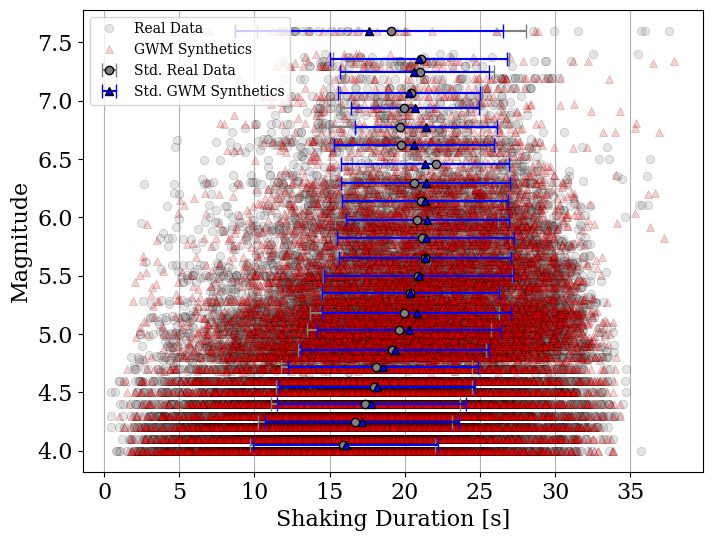

In [76]:
mag_bin = np.linspace(min(magnitude), max(magnitude)+1, 30)

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(dur_wf, magnitude, 'o', color="gray", alpha=0.2, markeredgecolor="k", markeredgewidth=0.5, label="Real Data")
ax.plot(dur_gwm, magnitude, '^', color="r", alpha=0.2, markeredgecolor="k", markeredgewidth=0.5, label="GWM Synthetics")

mag_mean = []
mean_dur_wf = []
std_dur_wf = []
mean_dur_gwm = []
std_dur_gwm = []
for i in range(len(mag_bin)-1):
    mag_masked = (magnitude >= mag_bin[i]) & (magnitude < mag_bin[i+1])
    mag_mean.append(np.mean(magnitude[mag_masked]))
    mean_dur_wf.append(np.mean(dur_wf[mag_masked]))
    std_dur_wf.append(np.std(dur_wf[mag_masked]))
    
    
    mean_dur_gwm.append(np.mean(dur_gwm[mag_masked]))
    std_dur_gwm.append(np.std(dur_gwm[mag_masked]))

ax.errorbar(mean_dur_wf, mag_mean, marker='o', xerr=std_dur_wf, capsize=5, color="gray", markeredgecolor="k", linestyle='', fmt='-.', label="Std. Real Data")
ax.errorbar(mean_dur_gwm, mag_mean, marker='^', xerr=std_dur_wf, capsize=5, color="blue", markeredgecolor="k", linestyle='', fmt='-', label="Std. GWM Synthetics")
ax.legend(fontsize=10)
ax.set_xlabel("Shaking Duration [s]")
ax.set_ylabel("Magnitude")
ax.grid(axis="x")
fig.savefig("figures/updated/signal_magnitude_all_mag.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/updated/signal_magnitude_all_mag.svg", dpi=300, bbox_inches="tight")

In [65]:
idx = 91
dataset_observed.hypocentral_distance[idx], dataset_observed.hypocentre_depth[idx], dataset_observed.magnitude[idx], dataset_observed.vs30s[idx], dataset_observed.azimuthal_gap[idx]


(44.092997998884265,
 38.0,
 5.105941261598646,
 181.3520070577856,
 240.15740313746994)

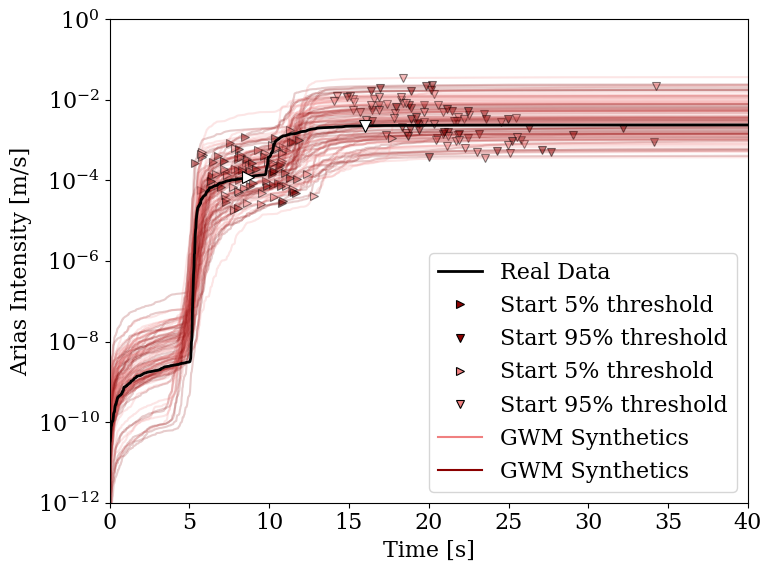

In [70]:
from matplotlib.legend_handler import HandlerTuple

dataset_generated = SeismicParameters('../experiments/workdir/new_highfem1/generated_waveforms_realizations.h5')
dataset_observed = SeismicParameters('../experiments/workdir/new_highfem1/test_data.h5')
dataset_observed.waveforms = rearrange(dataset_observed.waveforms, "b t c -> b c t")

waveforms = dataset_generated.waveforms
rhyp = dataset_generated.hypocentral_distance
magnitude = dataset_generated.magnitude
vs30 = dataset_generated.vs30s
real_data = dataset_observed.waveforms[:,:,:4064]

waveforms_NS = waveforms[:,0,:]
waveforms_EW = waveforms[:,1,:]

fig = plt.figure(figsize=(8, 6))
axs = fig.gca()
lower_percent=5; upper_percent=95


for i in range(0,100):
    if (max(waveforms_NS[i,:]) > 1) or (max(waveforms_NS[i,:]) < 2e-2):
        continue
    Ia, cumulative_Ia = calculate_arias_intensity(time, waveforms_NS[i,:])
    t_start, t_end, duration_Ia = calculate_signal_duration(time, cumulative_Ia, Ia, lower_percent=5, upper_percent=95)
    
    if np.mod(i,2) == 0:
        color = 'lightcoral'
    else:
        color = 'darkred'
    axs.plot(time, cumulative_Ia, c=color, alpha=0.2)
    axs.plot(t_start, (lower_percent / 100) * Ia, ">", color=color, alpha=0.5, markeredgecolor="k", markeredgewidth=0.8)
    axs.plot(t_end, (upper_percent / 100) * Ia, "v", color=color, alpha=0.5, markeredgecolor="k", markeredgewidth=0.8)
    
Ia, cumulative_Ia = calculate_arias_intensity(time, real_data[idx,0,:])
t_start, t_end, duration_Ia = calculate_signal_duration(time, cumulative_Ia, Ia, lower_percent=5, upper_percent=95)
axs.plot(time, cumulative_Ia, c='k', linewidth=2, label='Real Data')
axs.plot(t_start, (lower_percent / 100) * Ia, ">", markersize=9, color="white", alpha=1, markeredgecolor="k", markeredgewidth=0.8)
axs.plot(t_end, (upper_percent / 100) * Ia, "v", markersize=9, color="white", alpha=1, markeredgecolor="k", markeredgewidth=0.8)
axs.set_xlabel('Time [s]')
axs.set_ylabel('Arias Intensity [m/s]')
# axs.set_title('Cumulative Arias Intensity')
# axs.legend()
axs.set_xlim(0,40)
axs.set_ylim(1e-12,1)
axs.set_yscale("log")
ln1 = axs.plot([],[], '>', color='darkred', markeredgecolor="k", markeredgewidth=0.8, label="Start 5% threshold")
ln3 = axs.plot([],[], 'v', color='darkred', markeredgecolor="k", markeredgewidth=0.8, label="Start 95% threshold")
ln2 = axs.plot([],[], '>', color='lightcoral', markeredgecolor="k", markeredgewidth=0.8, label="Start 5% threshold")
ln4 = axs.plot([],[], 'v', color='lightcoral', markeredgecolor="k", markeredgewidth=0.8, label="Start 95% threshold")
axs.plot([],[], '-', color='lightcoral', label="GWM Synthetics")
axs.plot([],[], '-', color='darkred', label="GWM Synthetics")

axs.legend()
plt.tight_layout()
fig.savefig("figures/updated/cumulative_arias_intensity_log.svg", dpi=300, bbox_inches="tight")
plt.show()